In [1]:
#preprocess

import re
from core_character_alias_mapping_table import character_map

# Read the text of the novel
with open('pride_and_prejudice.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Alias standardization processing
def replace_aliases(text):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in character_map.keys()) + r')\b')
    return pattern.sub(lambda x: character_map[x.group()], text)

normalized_text = replace_aliases(text)

# Extract the co-occurrence relationship of characters
def extract_cooccurrences(text):
    #Match the speaking pattern
    dialog_pattern = re.compile(r'"(?:[^"]|"")*"\,\s+(said|replied|cried)\s+([A-Z][a-zA-Z]+)')

    # Match the co-occurring characters in the paragraph
    characters = set(character_map.values())
    cooccur = {}

    for paragraph in text.split('\n\n'):
        found = set()
        for char in characters:
            if re.search(r'\b' + char + r'\b', paragraph, re.IGNORECASE):
                found.add(char)

        # Record the co-occurrence relationship of paragraphs
        for a in found:
            for b in found:
                if a != b:
                    key = f"{a}-{b}"  # Convert the tuple to a string
                    cooccur[key] = cooccur.get(key, 0) + 1

    return cooccur

relation_data = extract_cooccurrences(normalized_text)

# Save the preprocessing result
import json
with open('relation_data.json', 'w') as f:
    json.dump(relation_data, f, indent=2)

In [2]:
#train model

from gensim.models import Word2Vec
import json
import numpy as np

# Load relational data
with open('relation_data.json') as f:
    relations = json.load(f)

# Build training data
sentences = []
for key, count in relations.items():
    char1, char2 = key.split('-')
    pairs = [[char1, char2] for _ in range(int(np.log(count)+1))]
    sentences.extend(pairs)

# training model
model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4
)

# Save the model
model.save("character_relations.model")

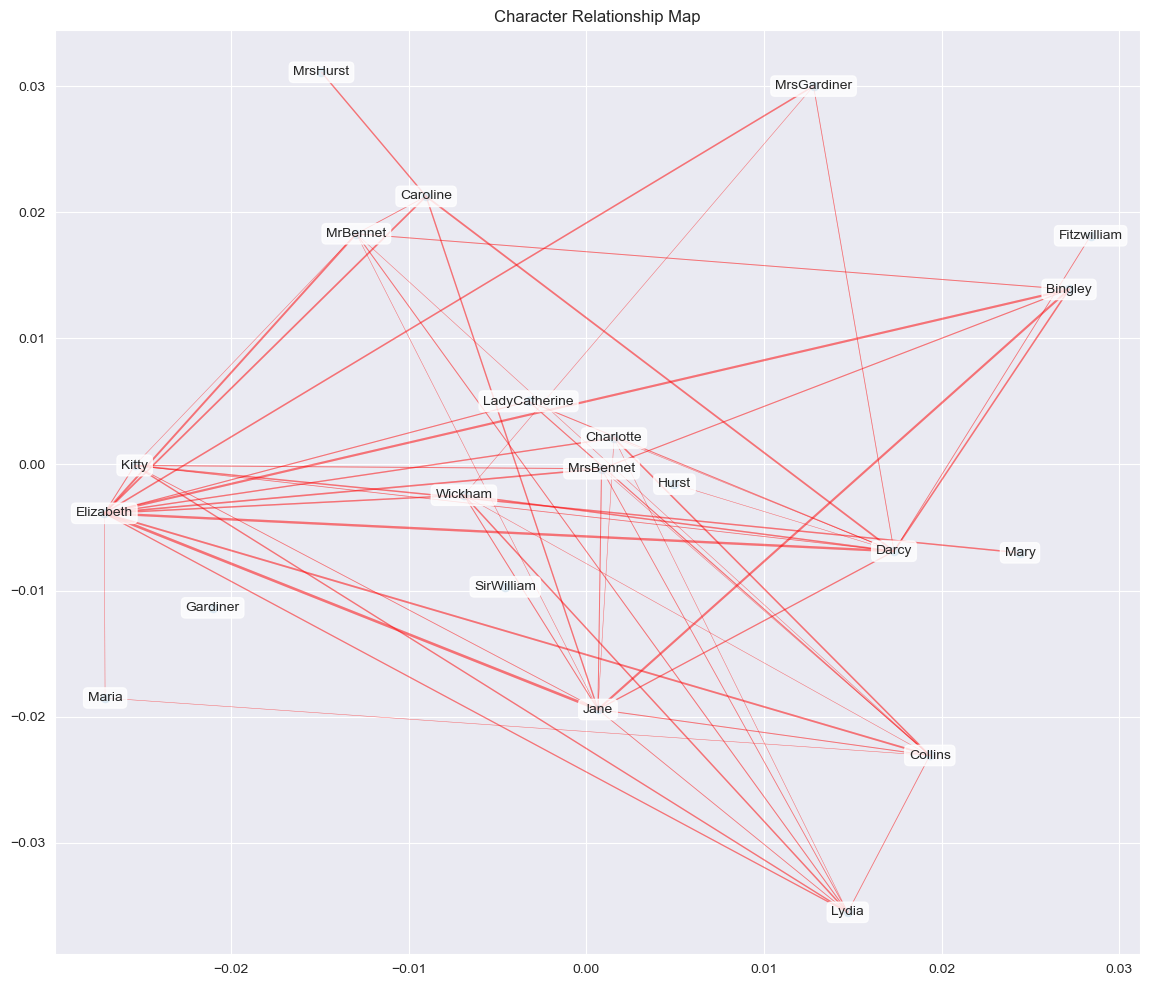

   CharacterA CharacterB  Co-occurrence  VectorSimilarity  Strength
16       Jane  Elizabeth             42            -0.047  3.737670
17  Elizabeth       Jane             42            -0.047  3.737670
13  Elizabeth      Darcy             29            -0.004  3.367296
15      Darcy  Elizabeth             29            -0.004  3.367296
2     Bingley  Elizabeth             21            -0.111  3.044522
3   Elizabeth    Bingley             21            -0.111  3.044522
30    Bingley       Jane             20            -0.012  2.995732
31       Jane    Bingley             20            -0.012  2.995732
8   Elizabeth   MrBennet             15             0.094  2.708050
9    MrBennet  Elizabeth             15             0.094  2.708050


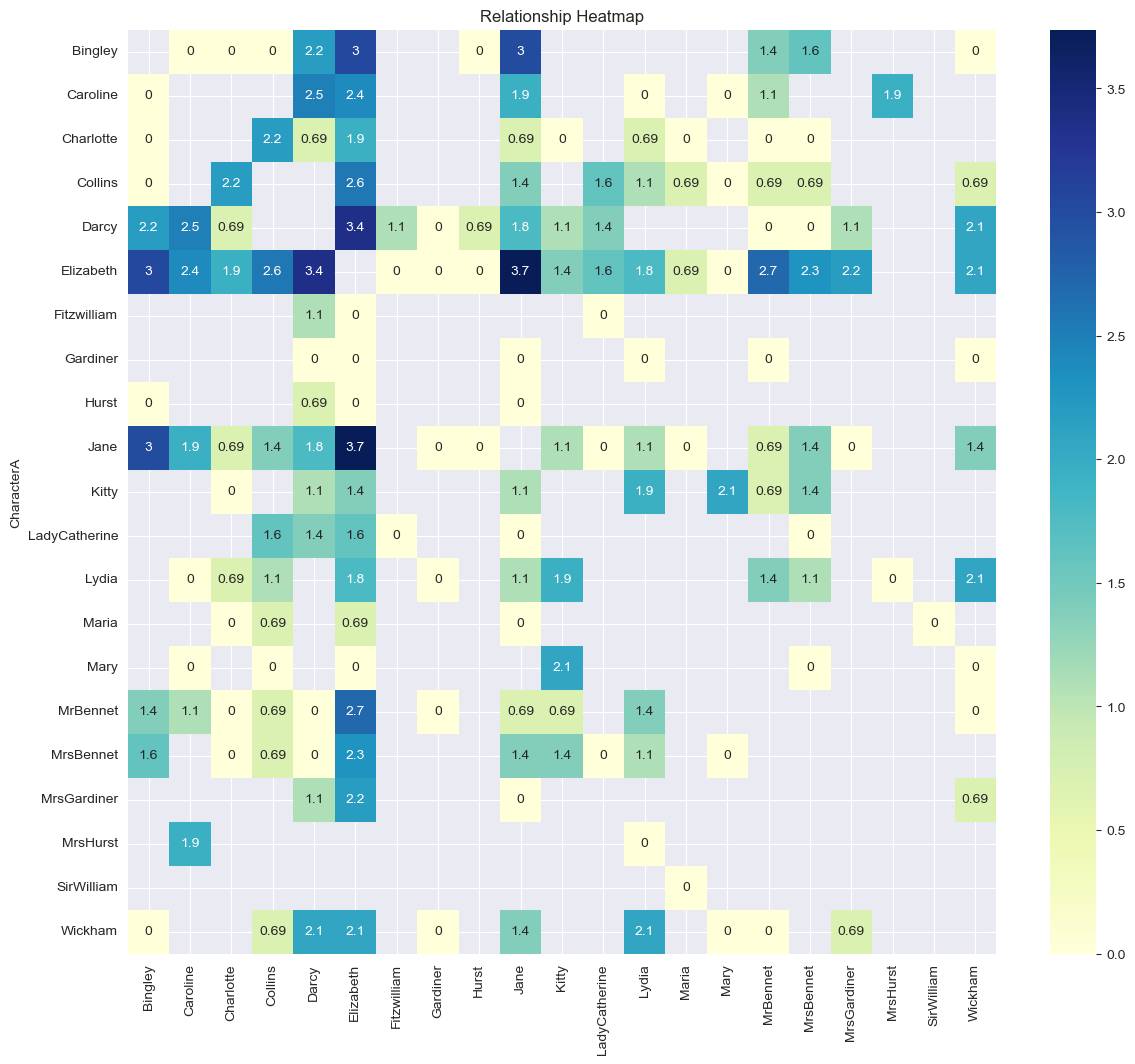

In [6]:
#visualize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import pandas as pd
import json  # 新增
import numpy as np  # 新增
import matplotlib

# 加载模型
model = Word2Vec.load("character_relations.model")

# 提取人物向量
characters = ['Elizabeth', 'Darcy', 'Bingley', 'Jane', 'MrsBennet', 'Wickham']
vectors = [model.wv[char] for char in characters]

# PCA降维
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)


# 新增表格生成函数
def generate_relation_table():
    # 加载所有人物
    with open('relation_data.json') as f:
        relations = json.load(f)
    all_chars = list({pair.split('-')[0] for pair in relations.keys()} | {pair.split('-')[1] for pair in relations.keys()})

    # 提取全部人物向量
    try:
        vectors = [model.wv[char] for char in all_chars]
    except KeyError as e:
        print(f"Missing character vector: {e}")

    # PCA降维应在动态加载人物后执行
    pca = PCA(n_components=2)
    result = pca.fit_transform(vectors)

    # 创建新画布
    plt.figure(figsize=(14,12))

    # 先绘制散点图
    plt.scatter(result[:,0], result[:,1], alpha=0.6)

    # 添加关系连线
    for pair, count in relations.items():
        char1, char2 = pair.split('-')
        try:
            idx1 = all_chars.index(char1)
            idx2 = all_chars.index(char2)
            line_width = np.log(count)/2
            plt.plot([result[idx1,0], result[idx2,0]],
                     [result[idx1,1], result[idx2,1]],
                     color='red', alpha=0.3, linewidth=line_width)  # 修改颜色为红色
        except (ValueError, IndexError):
            continue

# Finally, add labels
    for i, char in enumerate(all_chars):
        plt.annotate(char, xy=(result[i,0], result[i,1]),
                     fontsize=10, ha='center', va='center',
                     bbox=dict(boxstyle='round,pad=0.3',
                     facecolor='white', alpha=0.8))

    plt.title('Character Relationship Map')
    plt.savefig('relationship_map.png', dpi=300)
    plt.show()



    table_data = []
    # 修正循环结构
    for pair, count in relations.items():  # 恢复正确的items()遍历
        char1, char2 = pair.split('-')
        try:
            similarity = model.wv.similarity(char1, char2)
        except KeyError:
            similarity = 0

        table_data.append({
            'CharacterA': char1,
            'CharacterB': char2,
            'Co-occurrence': count,
            'VectorSimilarity': round(similarity, 3),
            'Strength': np.log(count)
        })

    # 创建双维度排序的DataFrame
    df = pd.DataFrame(table_data).sort_values(
        by=['Co-occurrence', 'VectorSimilarity'],
        ascending=[False, False]
    )

    # 保存增强版表格
    df.to_csv('combined_relations.csv', index=False)
    df.to_markdown('combined_relations.md', index=False)

    return df

# 在文件末尾调用
relation_table = generate_relation_table()
print(relation_table.head(10))
import seaborn as sns
heatmap_data = pd.read_csv('relationship_heatmap.csv', index_col=0)
plt.figure(figsize=(14,12))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
# 修改最后一个热力图标题
plt.title('Relationship Heatmap')
plt.savefig('heatmap.png', dpi=300)
